# Log Likelihood Debugging
Getting weird values for log likelihood when we extend p to be 0 and 1 beyond the bins that have persons in them.

In [529]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import logging
import matplotlib.pyplot as plt
import nirt.simulate.simulate_data
import nirt.solver
import numpy as np
import scipy.optimize

%load_ext autoreload
%autoreload 2

for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [530]:
np.random.seed(0)

# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Using 2-PL model with fixed discrimination and no asymptote for all items.
x, theta, b, c = nirt.simulate.simulate_data.generate_simulated_data(P, I, C, asym=0, discrimination=1)

In [531]:
# Build an IRF from some reasonable theta values.
num_bins = 10
sample_size = 20
theta = nirt.likelihood.initial_guess(x, c)
sample = np.random.choice(np.arange(P, dtype=int), size=sample_size * num_bins, replace=False)
grid = [nirt.grid.Grid(theta[sample, d], num_bins, method="uniform") for d in range(C)]
irf = [nirt.irf.ItemResponseFunction(grid[c[i]], x[:, i]) for i in range(I)]

In [532]:
items = np.where(c == d)[0]
print('d', d, 'items', items)

d 0 items [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


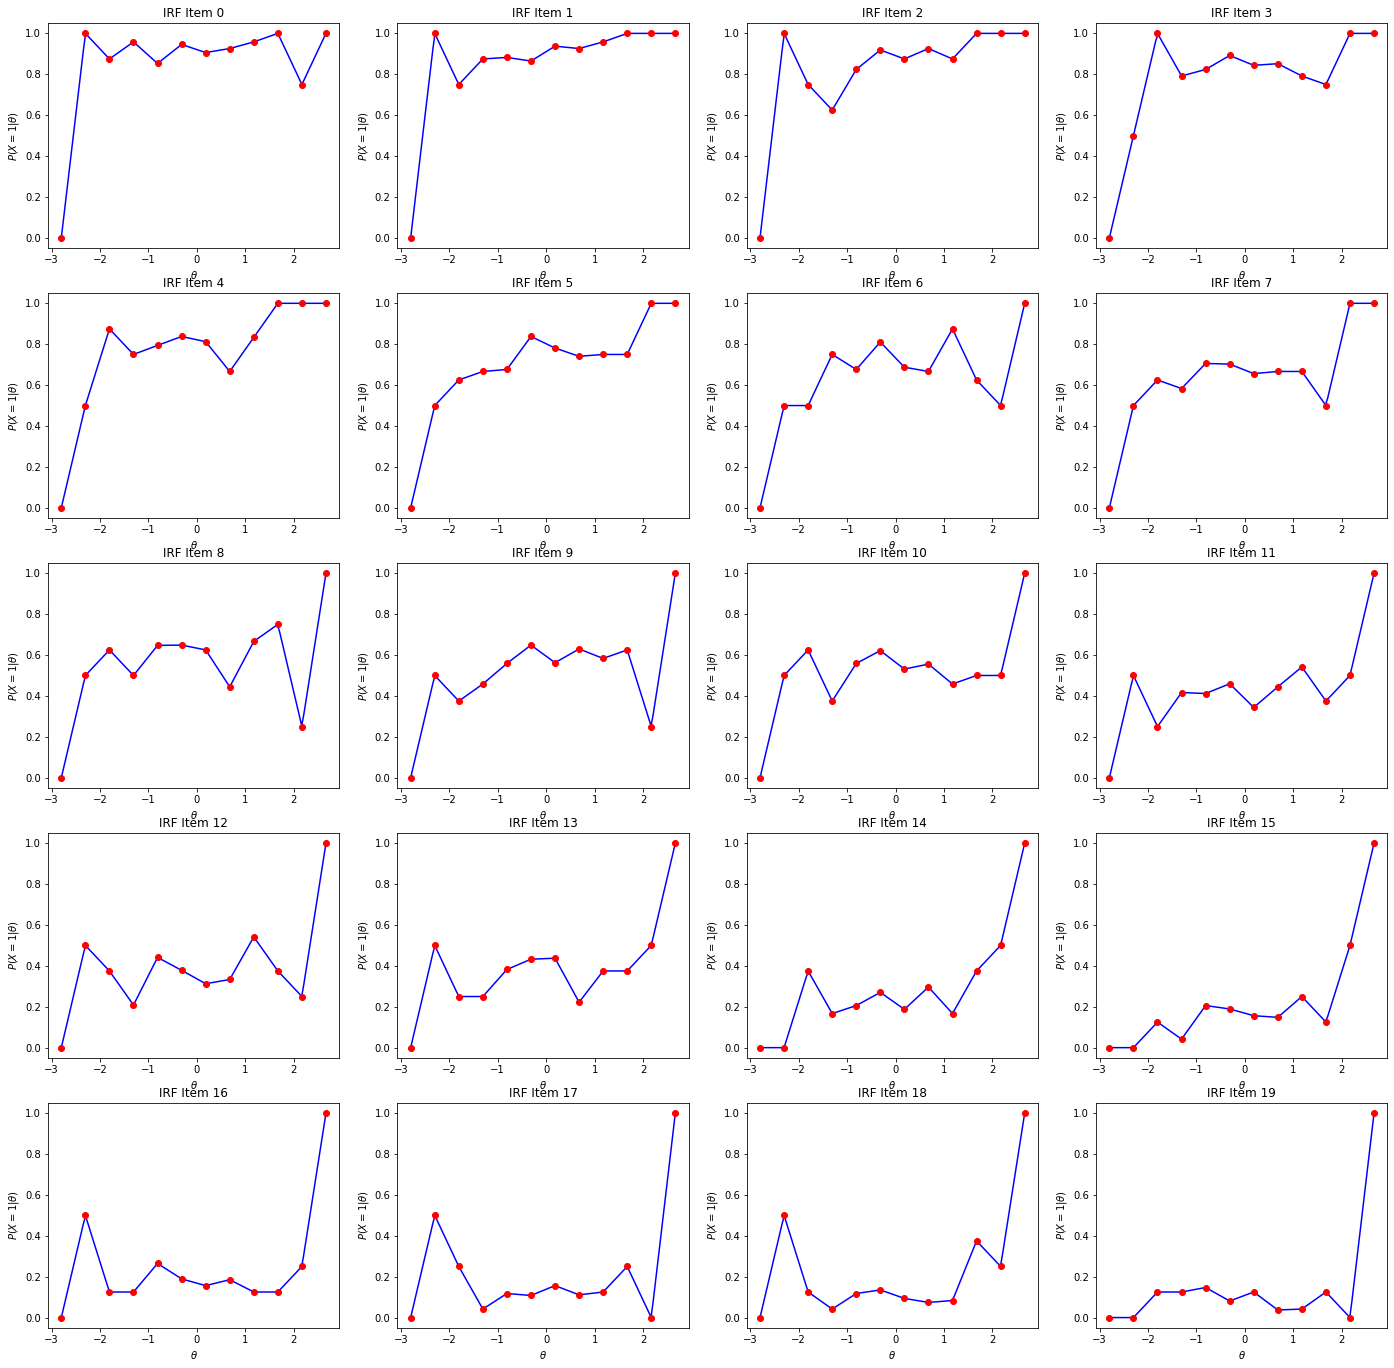

In [538]:
fig, axs = plt.subplots(len(items) // 4, 4, figsize=(24, 24))
for k, item in enumerate(items):
    ax = axs[k // 4, k % 4],
   irf[k].plot(ax, title="IRF Item {}".format(k))
    
# ax = plt.gca()
# k = I - 1
# irf[k].plot(ax, title="Item {}".format(k))
# ax.grid(True)

# print(irf[k].count)
# print(irf[k].probability)

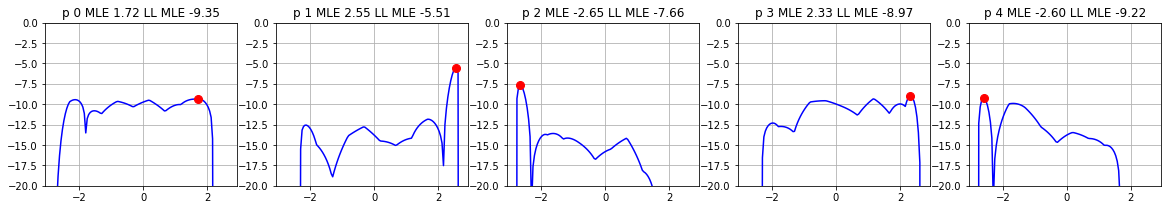

In [534]:
likelihood = nirt.likelihood.Likelihood(x, c, grid, irf)
d = 0

p_values = range(5)
fig, axs = plt.subplots(1, len(p_values), figsize=(20, 3))
for p in p_values:
    i = np.where(c == d)[0][0]
    t = np.linspace(irf[i].x[0], irf[i].x[-1], 10 * len(irf[i].x) + 1)
    active = np.tile([p, d], (len(t), 1))
    likelihood_values = likelihood.log_likelihood_term(t, active=(active[:, 0], active[:, 1]))

    # Verify that we can find the LL maximum with a root finder.
    t_mle = likelihood.parameter_mle(p, d, max_iter=10)
    likelihood_mle = likelihood.log_likelihood_term(t_mle, (np.array([p]), np.array([d])))[0]

    ax = axs if len(p_values) == 1 else axs[p]
    ax.plot(t, likelihood_values, 'b-')
    ax.grid(True)
    ax.set_ylim([-20, 0])
    ax.plot(np.array([t_mle]), np.array([likelihood_mle]), 'ro', markersize=8)
    ax.set_title("p {} MLE {:.2f} LL MLE {:.2f}".format(p, t_mle, likelihood_mle))

In [535]:
# MLE calculation using brute force (grid method). Slow.
# import time
# start = time.time()
# t = np.linspace(-3, 3, 100)
# d = 0
# for p in range(P):
#     active = np.tile([p, d], (len(t), 1))
#     F = likelihood.log_likelihood_term(t, active=(active[:, 0], active[:, 1]))
#     j = np.argmax(F)
#     #print(j, t[j], F[j])
# print("Time: {} s".format(time.time() - start))

In [536]:
# MLE - optimize in segment. Fast.
d = 0
start = time.time()
for p in range(P):
    active = (np.array([p]), np.array([d]))
    def f(theta_pc): return -likelihood.log_likelihood_term(np.array([theta_pc]), active=active)[0]
    e = grid[c[d]].endpoint
    max_iter = 2
    interval_min_result = (scipy.optimize.minimize_scalar(f, bracket=(e[j], e[j+1]), options={"maxiter": max_iter})
                           for j in range(len(e)-1))
    #print(min((result.fun, result.x) for result in interval_min_result))
print("Time: {} s".format(time.time() - start))

Time: 0.0030510425567626953 s
